In [1]:
import os
from time import time
import numpy as np
import sys
sys.path.append('../')

from utils.codification_cnn import FitnessCNNParallel
from utils.codification_grew import FitnessGrow, ChromosomeGrow, HyperParams, Merger
from utils.codification_grew import Inputs, MaxPooling, AvPooling, OperationBlock, CNNGrow, IdentityGrow
from utils.datamanager import DataManager
from GA.geneticAlgorithm import TwoLevelGA


Using TensorFlow backend.


In [2]:
# Chromosome parameters
ChromosomeGrow._max_initial_blocks = 5
ChromosomeGrow._grow_prob = 0.15
ChromosomeGrow._decrease_prob = 0.25


Merger._projection_type = ['normal', 'extend'][1]

HyperParams._GROW_RATE_LIMITS = [1.5, 5.]
HyperParams._N_CELLS = [1, 2]
HyperParams._N_BLOCKS = [2]
HyperParams._STEM = [32, 45]

OperationBlock._change_op_prob = 0.15
OperationBlock._change_concat_prob = 0.15

CNNGrow.filters_mul_range = [0.1, 1.2]
CNNGrow.possible_activations = ['relu', 'elu', 'prelu']
CNNGrow.dropout_range = [0, 0.7]
CNNGrow.possible_k = [1, 3, 5]
CNNGrow.k_prob = 0.2
CNNGrow.drop_prob = 0.2
CNNGrow.filter_prob = 0.2
CNNGrow.act_prob = 0.2

Inputs._mutate_prob = 0.5

    
data_folder = '../../datasets/MNIST_variations'
command = 'python3 ../train_gen.py'
verbose = 0

gpus = 2


In [3]:
# dataset params:
data_folder = data_folder
classes = []

# genetic algorithm params:
generations = 30
population_first_level = 20
population_second_level = 8
training_hours = 68
save_progress = True
maximize_fitness = False
statistical_validation = False
frequency_second_level = 3
start_level2 = 1


# Fitness params
epochs = 15
batch_size = 128
verbose = verbose
redu_plat = False
early_stop = 0
warm_up_epochs = 0
base_lr = 0.05
smooth = 0.1
cosine_dec = False
lr_find = False
precise_eps = 75

include_time = True
test_eps = 200
augment = False

datasets = ['fashion_mnist', 'MB', 'MBI', 'MRB', 'MRD', 'MRDBI']
datasets = ['fashion_mnist']

In [ ]:
fitness_cnn = FitnessGrow()    
c = ChromosomeGrow.random_individual()   
evolve_maxpool = False
experiments_folder = '../../exp_finals_pool_v2' if evolve_maxpool else '../../exp_finals_v2'
description = "Grow V2 Maxpool and AvgPool" if evolve_maxpool else "Grow V2"

experiments_folder = experiments_folder
os.makedirs(experiments_folder, exist_ok=True)
for dataset in datasets:
    if dataset == 'cifar10':
        test_eps = 200
        augment = 'cutout'
    else:
        test_eps = 100
        augment = False
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example')   
    os.makedirs(folder, exist_ok=True)

    try:
        generational = TwoLevelGA.load_genetic_algorithm(folder=folder)
        # Load data
        num_clases = 100 if dataset == 'cifar100' else 10
        dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder, num_clases=num_clases) #, max_examples=8000)
        data = dm.load_data()
        fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                       epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                       warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                       precise_epochs=precise_eps, include_time=include_time, test_eps=test_eps, augment=augment)

        fitness_cnn.save(fitness_file)
    except:
        # Load data
        num_clases = 100 if dataset == 'cifar100' else 10
        dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder, num_clases=num_clases) #, max_examples=8000)
        data = dm.load_data()
        fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                       epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                       warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                       precise_epochs=precise_eps, include_time=include_time, test_eps=test_eps,  augment=augment)

        fitness_cnn.save(fitness_file)

        del dm, data

        fitness = FitnessCNNParallel()
        fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                       fp=32, main_line=command)
        generational = TwoLevelGA(chromosome=c,
                                  fitness=fitness,
                                  generations=generations,
                                  population_first_level=population_first_level,
                                  population_second_level=population_second_level,
                                  training_hours=training_hours,
                                  save_progress=save_progress,
                                  maximize_fitness=maximize_fitness,
                                  statistical_validation=statistical_validation,
                                  folder=folder,
                                  start_level2=start_level2,
                                  frequency_second_level=frequency_second_level)
        generational.print_genetic(description)


    ti_all = time()
    print(generational.generation)
    print(generational.num_generations)
    if generational.generation < generational.num_generations:
        winner, best_fit, ranking = generational.evolve()
    print("Total elapsed time: %0.3f" % (time() - ti_all))


EVOLVING IN DATASET fashion_mnist ...

(48000, 28, 28, 1) train samples
(12000, 28, 28, 1) validation samples
(10000, 28, 28, 1) test samples
Number of individuals eliminated by age: 0
Genetic algorithm params
Number of generations: 30
Population size: 20
Folder to save: ../../exp_finals_v2/fashion_mnist/genetic/0_2020-03-02-12:54/GA_experiment
num parents: 5
offspring size: 15

Population size level one: 20
Population size level two: 8
Number of parents level one: 5
Number of parents level two: 4
Offspring size level one: 15
Offspring size level two: 4
Grow V2
0
30
Creating Initial population

Start evolution process...

Initial population initialization...20

0) Ranking level 1... Models to train: 20 ...OK (in 99.09 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.001

1) Ranking level 1... Models to train: 15 ...OK (in 89.05 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.001

1) Ranking level 2... Models to train: 8 ..

In [ ]:
for evolve_maxpool in [True, False]:
    if evolve_maxpool:
        OperationBlock._operations = [CNNGrow, IdentityGrow, MaxPooling, AvPooling]
    else:
        OperationBlock._operations = [CNNGrow, IdentityGrow]
        
    fitness_cnn = FitnessGrow()    
    c = ChromosomeGrow.random_individual()   
    experiments_folder = '../../exp_finals_pool' if evolve_maxpool else '../../exp_finals'
    description = "Grow V2 Maxpool and AvgPool" if evolve_maxpool else "Grow V2"
    
    experiments_folder = experiments_folder
    os.makedirs(experiments_folder, exist_ok=True)
    for dataset in datasets:
        if dataset == 'cifar10':
            test_eps = 200
            augment = 'cutout'
        print("\nEVOLVING IN DATASET %s ...\n" % dataset)
        exp_folder = os.path.join(experiments_folder, dataset)
        folder = os.path.join(exp_folder, 'genetic')
        fitness_folder = exp_folder
        fitness_file = os.path.join(fitness_folder, 'fitness_example')   
        os.makedirs(folder, exist_ok=True)

        try:
            generational = TwoLevelGA.load_genetic_algorithm(folder=folder)
            # Load data
            num_clases = 100 if dataset == 'cifar100' else 10
            dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder, num_clases=num_clases) #, max_examples=8000)
            data = dm.load_data()
            fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                           epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                           warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                           precise_epochs=precise_eps, include_time=include_time, test_eps=test_eps, augment=augment)

            fitness_cnn.save(fitness_file)
        except:
            # Load data
            num_clases = 100 if dataset == 'cifar100' else 10
            dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder, num_clases=num_clases) #, max_examples=8000)
            data = dm.load_data()
            fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                           epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                           warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                           precise_epochs=precise_eps, include_time=include_time, test_eps=test_eps,  augment=augment)

            fitness_cnn.save(fitness_file)

            del dm, data

            fitness = FitnessCNNParallel()
            fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                           fp=32, main_line=command)
            generational = TwoLevelGA(chromosome=c,
                                      fitness=fitness,
                                      generations=generations,
                                      population_first_level=population_first_level,
                                      population_second_level=population_second_level,
                                      training_hours=training_hours,
                                      save_progress=save_progress,
                                      maximize_fitness=maximize_fitness,
                                      statistical_validation=statistical_validation,
                                      folder=folder,
                                      start_level2=start_level2,
                                      frequency_second_level=frequency_second_level)
            generational.print_genetic(description)


        ti_all = time()
        print(generational.generation)
        print(generational.num_generations)
        if generational.generation < generational.num_generations:
            winner, best_fit, ranking = generational.evolve()
        print("Total elapsed time: %0.3f" % (time() - ti_all))




EVOLVING IN DATASET fashion_mnist ...

4423680/4422102 [==============================] - 2s 0us/step
(48000, 28, 28, 1) train samples
(12000, 28, 28, 1) validation samples
(10000, 28, 28, 1) test samples
Number of individuals eliminated by age: 0
Genetic algorithm params
Number of generations: 30
Population size: 20
Folder to save: ../../exp_finals_pool/fashion_mnist/genetic/0_2020-02-06-17:48/GA_experiment
num parents: 5
offspring size: 15

Population size level one: 20
Population size level two: 8
Number of parents level one: 5
Number of parents level two: 4
Offspring size level one: 15
Offspring size level two: 4
Grow V2 Maxpool and AvgPool
0
30
Creating Initial population

Start evolution process...

Initial population initialization...20

0) Ranking level 1... Models to train: 20 ...OK (in 5.04 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.001

1) Ranking level 1... Models to train: 15 ...

(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples
Training with learning rate: 0.07855550518176016

Epochs: 15
Warmup epochs: 1
Training... Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________


Train on 9600 samples, validate on 2400 samples
Epoch 1/15

Batch 00001: setting learning rate to 2e-05.
 128/9600 [..............................] - ETA: 15:35 - loss: 2.4506 - accuracy: 0.1328
Batch 00002: setting learning rate to 0.0010671400690901354.
 256/9600 [..............................] - ETA: 7:50 - loss: 2.4812 - accuracy: 0.1250 
Batch 00003: setting learning rate to 0.0021142801381802707.
 384/9600 [>.............................] - ETA: 5:14 - loss: 3.2472 - accuracy: 0.1224
Batch 00004: setting learning rate to 0.003161420207270406.
 512/9600 [>.............................] - ETA: 3:56 - loss: 3.8623 - accuracy: 0.0996
Batch 00005: setting learning rate to 0.004208560276360541.
 640/9600 [=>............................] - ETA: 3:10 - loss: 6.4704 - accuracy: 0.0922
Batch 00006: setting learning rate to 0.005255700345450677.
 768/9600 [=>............................] - ETA: 2:38 - loss: 10.6788 - accuracy: 0.0859
Batch 00007: setting learning rate to 0.0063028404145408

4480/9600 [=============>................] - ETA: 9s - loss: 1.1013 - accuracy: 0.7683 
Batch 00111: setting learning rate to 0.07593765500903484.
4608/9600 [=============>................] - ETA: 9s - loss: 1.1002 - accuracy: 0.7689
Batch 00112: setting learning rate to 0.07586285928981411.
4736/9600 [=============>................] - ETA: 9s - loss: 1.0981 - accuracy: 0.7690
Batch 00113: setting learning rate to 0.07578806357059338.
4864/9600 [==============>...............] - ETA: 9s - loss: 1.0959 - accuracy: 0.7699
Batch 00114: setting learning rate to 0.07571326785137265.
4992/9600 [==============>...............] - ETA: 8s - loss: 1.0929 - accuracy: 0.7716
Batch 00115: setting learning rate to 0.07563847213215193.
5120/9600 [===============>..............] - ETA: 8s - loss: 1.0895 - accuracy: 0.7736
Batch 00116: setting learning rate to 0.0755636764129312.
5248/9600 [===============>..............] - ETA: 8s - loss: 1.0862 - accuracy: 0.7761
Batch 00117: setting learning rate to

2048/9600 [=====>........................] - ETA: 13s - loss: 0.8668 - accuracy: 0.8906
Batch 00167: setting learning rate to 0.07174909473267428.
2176/9600 [=====>........................] - ETA: 13s - loss: 0.8638 - accuracy: 0.8920
Batch 00168: setting learning rate to 0.07167429901345355.
2304/9600 [======>.......................] - ETA: 13s - loss: 0.8646 - accuracy: 0.8915
Batch 00169: setting learning rate to 0.07159950329423283.
2432/9600 [======>.......................] - ETA: 13s - loss: 0.8669 - accuracy: 0.8882
Batch 00170: setting learning rate to 0.0715247075750121.
2560/9600 [=======>......................] - ETA: 13s - loss: 0.8634 - accuracy: 0.8891
Batch 00171: setting learning rate to 0.07144991185579139.
2688/9600 [=======>......................] - ETA: 12s - loss: 0.8621 - accuracy: 0.8906
Batch 00172: setting learning rate to 0.07137511613657066.
2816/9600 [=======>......................] - ETA: 12s - loss: 0.8645 - accuracy: 0.8896
Batch 00173: setting learning r

6656/9600 [===================>..........] - ETA: 5s - loss: 0.7670 - accuracy: 0.9205
Batch 00278: setting learning rate to 0.06344676989917393.
6784/9600 [====================>.........] - ETA: 5s - loss: 0.7673 - accuracy: 0.9207
Batch 00279: setting learning rate to 0.0633719741799532.
6912/9600 [====================>.........] - ETA: 5s - loss: 0.7660 - accuracy: 0.9213
Batch 00280: setting learning rate to 0.06329717846073248.
7040/9600 [=====================>........] - ETA: 4s - loss: 0.7656 - accuracy: 0.9213
Batch 00281: setting learning rate to 0.06322238274151175.
7168/9600 [=====================>........] - ETA: 4s - loss: 0.7647 - accuracy: 0.9220
Batch 00282: setting learning rate to 0.06314758702229102.
7296/9600 [=====================>........] - ETA: 4s - loss: 0.7643 - accuracy: 0.9219
Batch 00283: setting learning rate to 0.0630727913030703.
7424/9600 [======================>.......] - ETA: 4s - loss: 0.7637 - accuracy: 0.9219
Batch 00284: setting learning rate to 0

1536/9600 [===>..........................] - ETA: 15s - loss: 0.6840 - accuracy: 0.9518
Batch 00388: setting learning rate to 0.055219240784894284.
1664/9600 [====>.........................] - ETA: 15s - loss: 0.6800 - accuracy: 0.9531
Batch 00389: setting learning rate to 0.05514444506567356.
1792/9600 [====>.........................] - ETA: 15s - loss: 0.6814 - accuracy: 0.9515
Batch 00390: setting learning rate to 0.055069649346452844.
1920/9600 [=====>........................] - ETA: 14s - loss: 0.6830 - accuracy: 0.9521
Batch 00391: setting learning rate to 0.05499485362723212.
2048/9600 [=====>........................] - ETA: 14s - loss: 0.6841 - accuracy: 0.9526
Batch 00392: setting learning rate to 0.054920057908011397.
2176/9600 [=====>........................] - ETA: 14s - loss: 0.6854 - accuracy: 0.9522
Batch 00393: setting learning rate to 0.05484526218879067.
2304/9600 [======>.......................] - ETA: 14s - loss: 0.6833 - accuracy: 0.9536
Batch 00394: setting learni

8704/9600 [==========================>...] - ETA: 1s - loss: 0.6723 - accuracy: 0.9552
Batch 00444: setting learning rate to 0.051030680508533745.
8832/9600 [==========================>...] - ETA: 1s - loss: 0.6716 - accuracy: 0.9555
Batch 00445: setting learning rate to 0.05095588478931302.
8960/9600 [===========================>..] - ETA: 1s - loss: 0.6710 - accuracy: 0.9556
Batch 00446: setting learning rate to 0.0508810890700923.
9088/9600 [===========================>..] - ETA: 1s - loss: 0.6719 - accuracy: 0.9552
Batch 00447: setting learning rate to 0.05080629335087158.
9216/9600 [===========================>..] - ETA: 0s - loss: 0.6719 - accuracy: 0.9551
Batch 00448: setting learning rate to 0.05073149763165085.
9344/9600 [============================>.] - ETA: 0s - loss: 0.6711 - accuracy: 0.9554
Batch 00449: setting learning rate to 0.05065670191243012.
9472/9600 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.9557
Batch 00450: setting learning rate to

3584/9600 [==========>...................] - ETA: 11s - loss: 0.6358 - accuracy: 0.9657
Batch 00554: setting learning rate to 0.042803151394254106.
3712/9600 [==========>...................] - ETA: 11s - loss: 0.6368 - accuracy: 0.9652
Batch 00555: setting learning rate to 0.04272835567503339.
3840/9600 [===========>..................] - ETA: 10s - loss: 0.6361 - accuracy: 0.9651
Batch 00556: setting learning rate to 0.042653559955812666.
3968/9600 [===========>..................] - ETA: 10s - loss: 0.6360 - accuracy: 0.9652
Batch 00557: setting learning rate to 0.04257876423659194.
4096/9600 [===========>..................] - ETA: 10s - loss: 0.6365 - accuracy: 0.9646
Batch 00558: setting learning rate to 0.04250396851737121.
4224/9600 [============>.................] - ETA: 10s - loss: 0.6364 - accuracy: 0.9652
Batch 00559: setting learning rate to 0.04242917279815049.
4352/9600 [============>.................] - ETA: 9s - loss: 0.6359 - accuracy: 0.9653 
Batch 00560: setting learnin

8192/9600 [========================>.....] - ETA: 2s - loss: 0.6197 - accuracy: 0.9709
Batch 00665: setting learning rate to 0.034500826560753754.
8320/9600 [=========================>....] - ETA: 2s - loss: 0.6197 - accuracy: 0.9709
Batch 00666: setting learning rate to 0.03442603084153303.
8448/9600 [=========================>....] - ETA: 2s - loss: 0.6199 - accuracy: 0.9711
Batch 00667: setting learning rate to 0.0343512351223123.
8576/9600 [=========================>....] - ETA: 1s - loss: 0.6201 - accuracy: 0.9711
Batch 00668: setting learning rate to 0.03427643940309158.
8704/9600 [==========================>...] - ETA: 1s - loss: 0.6202 - accuracy: 0.9710
Batch 00669: setting learning rate to 0.03420164368387086.
8832/9600 [==========================>...] - ETA: 1s - loss: 0.6202 - accuracy: 0.9711
Batch 00670: setting learning rate to 0.03412684796465013.
8960/9600 [===========================>..] - ETA: 1s - loss: 0.6207 - accuracy: 0.9708
Batch 00671: setting learning rate to

3072/9600 [========>.....................] - ETA: 12s - loss: 0.5972 - accuracy: 0.9775
Batch 00775: setting learning rate to 0.02627329744647412.
3200/9600 [=========>....................] - ETA: 12s - loss: 0.5968 - accuracy: 0.9781
Batch 00776: setting learning rate to 0.026198501727253392.
3328/9600 [=========>....................] - ETA: 12s - loss: 0.5956 - accuracy: 0.9787
Batch 00777: setting learning rate to 0.02612370600803267.
3456/9600 [=========>....................] - ETA: 11s - loss: 0.5971 - accuracy: 0.9780
Batch 00778: setting learning rate to 0.026048910288811948.
3584/9600 [==========>...................] - ETA: 11s - loss: 0.5986 - accuracy: 0.9774
Batch 00779: setting learning rate to 0.02597411456959122.
3712/9600 [==========>...................] - ETA: 11s - loss: 0.5979 - accuracy: 0.9779
Batch 00780: setting learning rate to 0.025899318850370497.
3840/9600 [===========>..................] - ETA: 11s - loss: 0.5976 - accuracy: 0.9781
Batch 00781: setting learni

7680/9600 [=======================>......] - ETA: 3s - loss: 0.5967 - accuracy: 0.9773
Batch 00886: setting learning rate to 0.017970972612973757.
7808/9600 [=======================>......] - ETA: 3s - loss: 0.5964 - accuracy: 0.9776
Batch 00887: setting learning rate to 0.01789617689375303.
7936/9600 [=======================>......] - ETA: 3s - loss: 0.5969 - accuracy: 0.9776
Batch 00888: setting learning rate to 0.017821381174532306.
8064/9600 [========================>.....] - ETA: 3s - loss: 0.5967 - accuracy: 0.9776
Batch 00889: setting learning rate to 0.01774658545531158.
8192/9600 [========================>.....] - ETA: 2s - loss: 0.5967 - accuracy: 0.9778
Batch 00890: setting learning rate to 0.01767178973609087.
8320/9600 [=========================>....] - ETA: 2s - loss: 0.5966 - accuracy: 0.9780
Batch 00891: setting learning rate to 0.017596994016870142.
8448/9600 [=========================>....] - ETA: 2s - loss: 0.5965 - accuracy: 0.9781
Batch 00892: setting learning rate

2560/9600 [=======>......................] - ETA: 14s - loss: 0.5830 - accuracy: 0.9816
Batch 00996: setting learning rate to 0.009743443498694127.
2688/9600 [=======>......................] - ETA: 13s - loss: 0.5830 - accuracy: 0.9818
Batch 00997: setting learning rate to 0.009668647779473401.
2816/9600 [=======>......................] - ETA: 13s - loss: 0.5838 - accuracy: 0.9819
Batch 00998: setting learning rate to 0.009593852060252676.
2944/9600 [========>.....................] - ETA: 13s - loss: 0.5837 - accuracy: 0.9820
Batch 00999: setting learning rate to 0.00951905634103195.
3072/9600 [========>.....................] - ETA: 13s - loss: 0.5856 - accuracy: 0.9811
Batch 01000: setting learning rate to 0.009444260621811225.
3200/9600 [=========>....................] - ETA: 12s - loss: 0.5865 - accuracy: 0.9803
Batch 01001: setting learning rate to 0.0093694649025905.
3328/9600 [=========>....................] - ETA: 12s - loss: 0.5859 - accuracy: 0.9808
Batch 01002: setting learni

Epoch 15/15

Batch 01051: setting learning rate to 0.005629678941554305.
 128/9600 [..............................] - ETA: 20s - loss: 0.5705 - accuracy: 0.9688
Batch 01052: setting learning rate to 0.0055548832223335795.
 256/9600 [..............................] - ETA: 19s - loss: 0.5817 - accuracy: 0.9766
Batch 01053: setting learning rate to 0.005480087503112854.
 384/9600 [>.............................] - ETA: 18s - loss: 0.5886 - accuracy: 0.9792
Batch 01054: setting learning rate to 0.005405291783892129.
 512/9600 [>.............................] - ETA: 18s - loss: 0.5877 - accuracy: 0.9805
Batch 01055: setting learning rate to 0.005330496064671403.
 640/9600 [=>............................] - ETA: 17s - loss: 0.5803 - accuracy: 0.9844
Batch 01056: setting learning rate to 0.005255700345450691.
 768/9600 [=>............................] - ETA: 17s - loss: 0.5838 - accuracy: 0.9792
Batch 01057: setting learning rate to 0.0051809046262299655.
 896/9600 [=>........................

7168/9600 [=====================>........] - ETA: 4s - loss: 0.5804 - accuracy: 0.9821
Batch 01107: setting learning rate to 0.0014411186651937583.
7296/9600 [=====================>........] - ETA: 4s - loss: 0.5807 - accuracy: 0.9819
Batch 01108: setting learning rate to 0.0013663229459730327.
7424/9600 [======================>.......] - ETA: 4s - loss: 0.5807 - accuracy: 0.9820
Batch 01109: setting learning rate to 0.0012915272267523207.
7552/9600 [======================>.......] - ETA: 4s - loss: 0.5807 - accuracy: 0.9820
Batch 01110: setting learning rate to 0.0012167315075315953.
7680/9600 [=======================>......] - ETA: 3s - loss: 0.5807 - accuracy: 0.9819
Batch 01111: setting learning rate to 0.0011419357883108697.
7808/9600 [=======================>......] - ETA: 3s - loss: 0.5802 - accuracy: 0.9822
Batch 01112: setting learning rate to 0.0010671400690901443.
7936/9600 [=======================>......] - ETA: 3s - loss: 0.5801 - accuracy: 0.9822
Batch 01113: setting lear

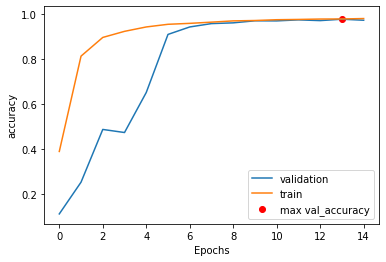

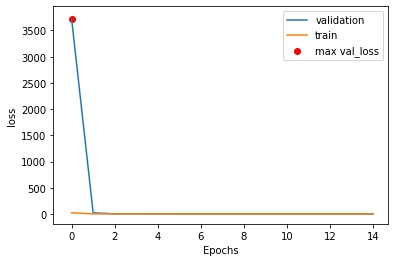

0.0213 in 6.2 min



0.021250009536743164

In [8]:
num_clases = 100 if dataset == 'cifar100' else 10
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder, num_clases=num_clases) #, max_examples=8000)
data = dm.load_data()
fitness_cnn.set_params(data=data, verbose=True, batch_size=batch_size, reduce_plateau=redu_plat,
               epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
               warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
               precise_epochs=precise_eps, include_time=include_time, test_eps=test_eps, augment=augment)

fitness_cnn.calc(c)

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
# experiments_folder = '../../exp_cifar10_time'
experiments_folder = '../../exp_mnist_grow_v2'
dataset = datasets[0]
exp_folder = os.path.join(experiments_folder, dataset)
folder = os.path.join(exp_folder, 'genetic')


generational = TwoLevelGA.load_genetic_algorithm(folder=folder)
# generational.finishing_evolution(show=True)


Loading file ../../exp_mnist_grow_v2/cifar10/genetic/0_2020-01-31-15:39/GA_experiment


In [9]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

winner = generational.best_individual['winner']
fit = generational.best_individual['best_fit']
test = generational.best_individual["test"]
print(winner)
print(1 - fit)
print(1 - test, test)



||CNN|F:1.1|K:5|A:relu|D:0.05||woCAT||1||
||CNN|F:1.0|K:5|A:relu|D:0.05||CAT||11||
||CNN|F:0.9|K:3|A:prelu|D:0.10||CAT||101||
HP->|GR:4.20|CELL:2|BLOCK:2|STEM:45|LR:0.0112|WU:0.2

0.9375290000000001
0.9523 0.0477


In [14]:
# Load data
num_clases = 100 if dataset == 'cifar100' else 10
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder, num_clases=num_clases) #, max_examples=8000)
data = dm.load_data()
fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
               epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
               warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
               precise_epochs=precise_eps, include_time=include_time, test_eps=test_eps, augment=augment)
print(fitness_cnn.augment)

(40000, 32, 32, 3) train samples
(10000, 32, 32, 3) validation samples
(10000, 32, 32, 3) test samples
cutout


In [16]:
fitness_cnn.verb = True
fitness_cnn.augment = False
score = fitness_cnn.calc(winner, test=True, precise_mode=True)

Training... Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 45)   1260        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 45)   180         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 45)   0           batch_normalization_1[0][0]      
________________________________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 147s 3ms/step - loss: 1.5698 - accuracy: 0.5159 - val_loss: 2.3153 - val_accuracy: 0.2674
Epoch 2/200
50000/50000 [==============================] - 144s 3ms/step - loss: 1.2089 - accuracy: 0.7019 - val_loss: 0.8119 - val_accuracy: 0.7321
Epoch 3/200
50000/50000 [==============================] - 144s 3ms/step - loss: 1.0332 - accuracy: 0.7871 - val_loss: 0.6999 - val_accuracy: 0.7789
Epoch 4/200
50000/50000 [==============================] - 144s 3ms/step - loss: 0.8998 - accuracy: 0.8480 - val_loss: 0.5612 - val_accuracy: 0.8155
Epoch 5/200
50000/50000 [==============================] - 144s 3ms/step - loss: 0.8045 - accuracy: 0.8878 - val_loss: 0.5582 - val_accuracy: 0.8309
Epoch 6/200
50000/50000 [==============================] - 144s 3ms/step - loss: 0.7263 - accuracy: 0.9231 - val_loss: 0.6148 - val_accuracy: 0.8140
Epoch 7/200
  640/50000 [..............................]

KeyboardInterrupt: 